Can I reproduce the fit parameters produced by the Cosmicflows-4 team for the Coma cluster?

(https://ui.adsabs.harvard.edu/abs/2020ApJ...896....3K/abstract)

In [1]:
import numpy as np

from astropy.io import fits
from astropy.table import Table

from sklearn.linear_model import LinearRegression

from line_fits import lls_line, hyperfit_line, param_invert, chi2_line_sigmax

from ltsfit import lts_linefit

import matplotlib.pyplot as plt

In [2]:
V0 = 2.5

# Import data

This is Table 1 from Kourkchi20a (https://ui.adsabs.harvard.edu/abs/2020ApJ...896....3K/abstract)

In [3]:
table1_filename = '/Users/kellydouglass/Documents/Research/data/Cosmicflows-4/Kourkchi20a_table1.fit'

hdul = fits.open(table1_filename)
t1 = hdul[1].data
hdul.close()

table1 = Table([t1['logWmxi'], t1['e_logWmxi'], t1['i_mag'], t1['Cl']], names=['logWmxi', 'e_logWmxi', 'i_mag', 'cluster'])

table1[:5]

logWmxi,e_logWmxi,i_mag,cluster
float64,float64,float64,str13
2.658,0.005,9.35,ZP calibrator
2.311,0.021,0.0,ZP calibrator
2.404,0.03,14.37,NGC70
2.635,0.024,12.68,NGC70
2.397,0.033,15.02,NGC70


## Make a smaller table with just the Coma cluster

In [4]:
np.unique(table1['cluster'])

Abell 1367
Abell 1367*
Abell 2151
Abell 262
Abell 262*
Abell 2634/66
Abell 400
Abell 539
Antlia
...
NGC410


In [5]:
coma = table1[table1['cluster'] == 'Coma         ']

coma[:5]

logWmxi,e_logWmxi,i_mag,cluster
float64,float64,float64,str13
2.576,0.011,13.47,Coma
2.587,0.018,13.49,Coma
2.685,0.018,12.88,Coma
2.551,0.023,13.49,Coma
2.685,0.008,13.27,Coma


# Plot the data

Let's take a look at the data before we do any fitting.

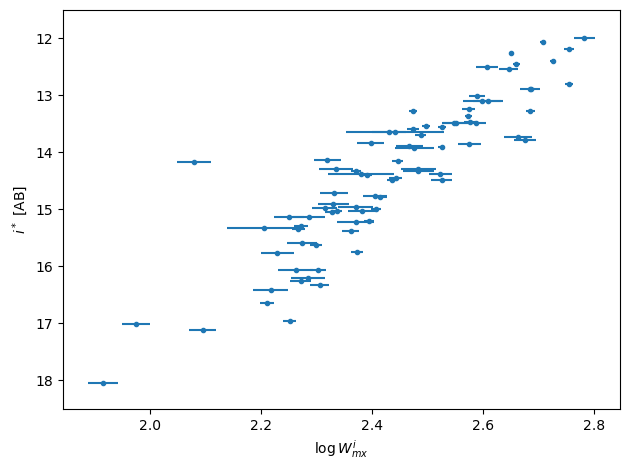

In [6]:
plt.figure(tight_layout=True)

plt.errorbar(coma['logWmxi'], coma['i_mag'], 
             xerr=coma['e_logWmxi'], 
             fmt='.')

plt.xlabel(r'$\log W^i_{mx}$')
plt.ylabel('$i^*$ [AB]')

plt.ylim(18.5, 11.5);

# Fit the TFR

We are using linear least squares, repeating what Cosmicflows-4 used.

In [7]:
x = coma['i_mag']
y = coma['logWmxi'] - V0
yerr = coma['e_logWmxi']

A = np.vander(x, 2)
C = np.diag(yerr*yerr)

ATA = np.dot(A.T, A/(yerr**2)[:, None])

cov = np.linalg.inv(ATA)

w = np.linalg.solve(ATA, np.dot(A.T, y/yerr**2))

#reg = LinearRegression().fit(x.reshape(-1, 1), y, 1./yerr**2)

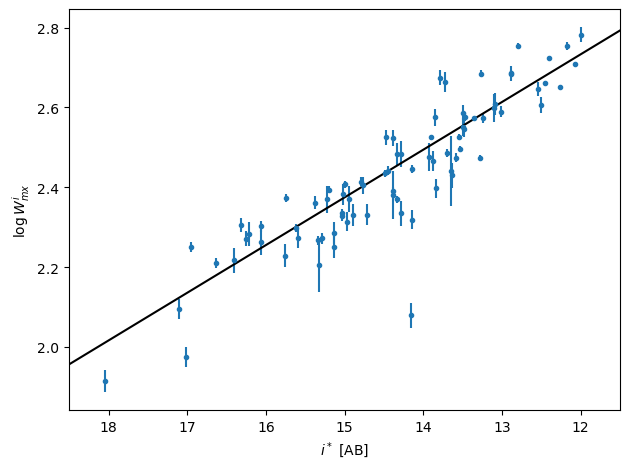

In [8]:
w0 = w[0]
w1 = w[1]
'''
w0 = reg.coef_[0]
w1 = reg.intercept_
'''

plt.figure(tight_layout=True)

plt.errorbar(coma['i_mag'], coma['logWmxi'], 
             yerr=coma['e_logWmxi'], 
             fmt='.')

plt.plot([11.5, 18.5], w0*np.array([11.5, 18.5]) + w1 + V0, 'k')

plt.ylabel(r'$\log W^i_{mx}$')
plt.xlabel('$i^*$ [AB]')

plt.xlim(18.5, 11.5);

In [9]:
lls_m = 1./w0
lls_b = -w1/w0

lls_dm = lls_m**2 * np.sqrt(cov[0,0])
lls_db = np.sqrt( (lls_b/w0)**2 * cov[0,0] + lls_m**2 * cov[1,1] + 2*(lls_b/lls_m**2) * cov[1,0] )

rng = np.random.default_rng()
w0_rng, w1_rng = rng.multivariate_normal([w0, w1], cov, 5000).T
m_rng = 1./w0_rng
b_rng = -w1_rng/w0_rng
mb_rng = np.stack((m_rng, b_rng))
cov_mb = np.cov(mb_rng)

print(f'{lls_m:.2f} +/- {lls_dm:.3f} or {np.sqrt(cov_mb[0,0]):.3f}')
print(f'{lls_b:.2f} +/- {lls_db:.3f} or {np.sqrt(cov_mb[1,1]):.3f}')

-8.37 +/- 0.072 or 0.072
13.95 +/- 0.168 or 0.011


They have

\begin{equation}
  m = -8.68 \pm 0.40 \qquad \qquad b = 13.94 \pm 0.06
\end{equation}

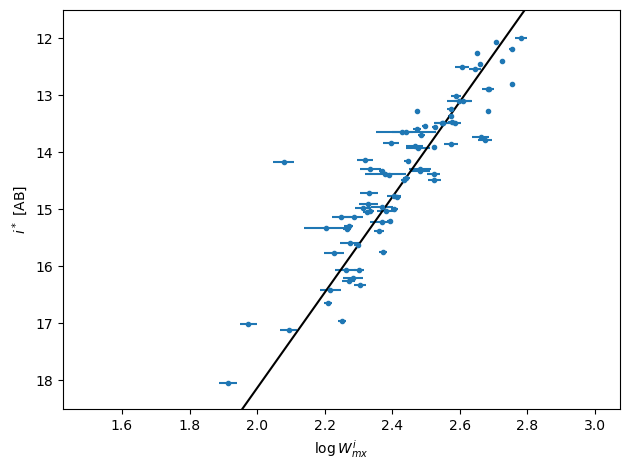

In [10]:
plt.figure(tight_layout=True)

plt.errorbar(coma['logWmxi'], coma['i_mag'], 
             xerr=coma['e_logWmxi'], 
             fmt='.')

plt.plot([1.5, 3], lls_m*(np.array([1.5, 3]) - V0) + lls_b, 'k')

plt.xlabel(r'$\log W^i_{mx}$')
plt.ylabel('$i^*$ [AB]')

plt.ylim(18.5, 11.5);

## They do throw out a few of the galaxies while fitting.  If we discard the same ones, do we reproduce their parameters?

In [11]:
cut1 = coma['i_mag'] >= 18

cut2 = (coma['i_mag'] < 14.5) & (coma['logWmxi'] < 2.2)

CF_coma = coma[~cut1 & ~cut2]

In [12]:
x = CF_coma['i_mag']
y = CF_coma['logWmxi'] - V0
yerr = CF_coma['e_logWmxi']

A = np.vander(x, 2)

ATA = np.dot(A.T, A/(yerr**2)[:, None])

cov_cut = np.linalg.inv(ATA)

w_cut = np.linalg.solve(ATA, np.dot(A.T, y/yerr**2))

#reg_cut = LinearRegression().fit(x.reshape(-1, 1), y, 1./yerr**2)

In [13]:
ATA

array([[1.12592366e+08, 8.21192855e+06],
       [8.21192855e+06, 6.03879369e+05]])

In [14]:
w0_cut = w_cut[0]
w1_cut = w_cut[1]
'''
w0_cut = reg_cut.coef_[0]
w1_cut = reg_cut.intercept_
''';

print(w0_cut, w1_cut)

-0.11857981032193061 1.655554651874861


In [15]:
lls_m_cut = 1./w0_cut
lls_b_cut = -w1_cut/w0_cut

lls_dm_cut = lls_m_cut**2 * np.sqrt(cov_cut[0,0])
lls_db_cut = np.sqrt( (lls_b_cut/w0_cut)**2 * cov_cut[0,0] + lls_m_cut**2 * cov_cut[1,1] + 2*(lls_b_cut/lls_m_cut**2) * cov_cut[1,0] )

w0_cut_rng, w1_cut_rng = rng.multivariate_normal([w0_cut, w1_cut], cov_cut, 5000).T
m_cut_rng = 1./w0_cut_rng
b_cut_rng = -w1_cut_rng/w0_cut_rng
mb_cut_rng = np.stack((m_cut_rng, b_cut_rng))
cov_mb_cut = np.cov(mb_cut_rng)

print(f'{lls_m_cut:.2f} +/- {lls_dm_cut:.3f} or {np.sqrt(cov_mb_cut[0,0]):.3f}')
print(f'{lls_b_cut:.2f} +/- {lls_db_cut:.3f} or {np.sqrt(cov_mb_cut[1,1]):.3f}')

-8.43 +/- 0.074 or 0.074
13.96 +/- 0.172 or 0.011


Nope, still doesn't match.  So I must be doing something wrong.

In [16]:
from line_fits import lls_line, param_invert

In [17]:
w0_cut, w1_cut, cov_cut = lls_line(CF_coma['i_mag'], CF_coma['logWmxi'] - V0, CF_coma['e_logWmxi'])

m_cut, b_cut, cov_mb_cut = param_invert(w0_cut, w1_cut, cov_cut)

print(f'{m_cut:.2f} +/- {np.sqrt(cov_mb_cut[0,0]):.3f}')
print(f'{b_cut:.2f} +/- {np.sqrt(cov_mb_cut[1,1]):.3f}')

-8.43 +/- 0.073
13.96 +/- 0.012


### What does this fit look like if I use `hyperfit`?

In [18]:
w0_hf, w1_hf, wsig_hf, cov_w_hf, w_mcmc_samples = hyperfit_line(CF_coma['i_mag'], 
                                                                CF_coma['logWmxi'] - V0, 
                                                                np.zeros(len(CF_coma)), 
                                                                CF_coma['e_logWmxi'], 
                                                                ((-10, 10), (-100, 100), (1e-5, 1000)))

m_hf, b_hf, cov_mb_hf = param_invert(w0_hf, w1_hf, cov_w_hf[:2,:2])

 message: Optimization terminated successfully.
 success: True
     fun: -175.85414926751568
       x: [ 1.993e-01  1.653e+00  6.142e-02]
     nit: 112
    nfev: 5105
     jac: [-1.484e-03 -1.416e-02  1.201e-01]


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1213.95it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [35.59863479 34.7289877  34.98074134] / 1779.931739479735


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1252.63it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [51.93989286 51.44381946 41.7980101 ] / 2596.994643204712


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1242.35it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [55.74324099 55.04365147 42.58842339] / 2787.1620493564274


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1146.35it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [45.55141925 44.78071093 34.59011701] / 2277.570962314675


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1247.84it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [48.19559742 47.77507077 44.46495709] / 2409.779871199283


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1259.15it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [44.0930695  43.82027861 43.83319058] / 2204.6534750671085


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1237.86it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [48.39325459 47.44953447 45.28564117] / 2419.662729424215


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1248.77it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [47.36700353 46.17016395 42.50538428] / 2368.3501765863257


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1250.81it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [52.04016476 50.71947898 43.5587983 ] / 2602.008237828979


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1243.53it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [47.68899809 46.63510772 41.34838028] / 2384.4499044216523


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1254.64it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [46.77893229 45.9687076  41.47524348] / 2338.9466145901088


In [19]:
print(f'{m_hf:.2f} +/- {np.sqrt(cov_mb_hf[0,0]):.3f}')
print(f'{b_hf:.2f} +/- {np.sqrt(cov_mb_hf[1,1]):.3f}')

-8.26 +/- 0.413
13.91 +/- 0.065


These uncertainties are *very* similar to what is reported in Cosmicflows-4.  I wonder if they are doing a generalized least squares fit, accounting for some vertical scatter.

In [20]:
m1_hf, b1_hf, sig1_hf, cov_mb1_hf, mcmc_samples = hyperfit_line(CF_coma['logWmxi'] - V0, 
                                                                CF_coma['i_mag'], 
                                                                CF_coma['e_logWmxi'], 
                                                                np.zeros(len(CF_coma)), 
                                                                ((-10, 10), (-100, 100), (1e-5, 1000)))

 message: Optimization terminated successfully.
 success: True
     fun: -175.85414864281424
       x: [ 1.653e+00  1.993e-01  6.141e-02]
     nit: 96
    nfev: 4381
     jac: [-1.989e-02 -4.636e-03 -7.162e-04]


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1228.02it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [33.32560284 32.86043664 33.78953378] / 1689.476688905003


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1264.11it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [43.88136121 43.15421057 36.45332138] / 2194.068060404505


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1259.76it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [38.67424897 38.46826967 47.36035956] / 2368.017978022352


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1250.30it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [37.2293289  36.94805679 46.75991078] / 2337.9955391678354


In [21]:
print(f'{m1_hf:.2f} +/- {np.sqrt(cov_mb1_hf[0,0]):.3f}')
print(f'{b1_hf:.2f} +/- {np.sqrt(cov_mb1_hf[1,1]):.3f}')

-8.29 +/- 0.425
13.91 +/- 0.069


Interesting - I get almost the same slope and y-intercept whether I fit the TFR or ITFR.

### What does the fit look like if I use a generalized least squares?

Here, we are using the `ltsfit` package.

In [22]:
w_gls = lts_linefit.lts_linefit(CF_coma['i_mag'], 
                                CF_coma['logWmxi'] - V0, 
                                np.zeros(len(CF_coma)), 
                                CF_coma['e_logWmxi'], 
                                frac=1, # Turns off the outlier detection, so that none are removed from the fit
                                plot=False)

sig_int:     0.0000     24.4160
Computing sig_int
sig_int:     0.0000     24.4160
sig_int:     0.0835     -0.4037
sig_int:     0.0821     -0.3852
sig_int:     0.0542      0.3004
sig_int:     0.0664     -0.0937
sig_int:     0.0635     -0.0177
sig_int:     0.0629      0.0003
sig_int:     0.0629     -0.0006
Computing sig_int error
sig_int:     0.0629      0.1614
sig_int:     0.0835     -0.2425
sig_int:     0.0711     -0.0378
sig_int:     0.0695     -0.0048
sig_int:     0.0693      0.0000
sig_int:     0.0694     -0.0007
Repeat at best fitting solution
sig_int:     0.0629      0.0003
################# Values and formal errors ################
 intercept:  1.673 +/- 0.085
     slope:  -0.1203 +/- 0.0059
   scatter:  0.0629 +/- 0.0065
Observed rms scatter: 0.067
Spearman r=-0.92 and p=1.5e-33
Pearson r=-0.91 and p=4.5e-32
##########################################################
seconds 0.03


In [23]:
wcov_gls = np.identity(2)
wcov_gls[0,0] = w_gls.ab_err[1]**2
wcov_gls[1,1] = w_gls.ab_err[0]**2

m_gls, b_gls, cov_gls = param_invert(w_gls.ab[1], w_gls.ab[0], wcov_gls)

In [24]:
print(f'{m_gls:.2f} +/- {np.sqrt(cov_gls[0,0]):.3f}')
print(f'{b_gls:.2f} +/- {np.sqrt(cov_gls[1,1]):.3f}')

-8.31 +/- 0.415
13.90 +/- 1.003


In [31]:
ab_gls = lts_linefit.lts_linefit(CF_coma['logWmxi'], 
                                 CF_coma['i_mag'], 
                                 CF_coma['e_logWmxi'], 
                                 0.0001*np.ones(len(CF_coma)), 
                                 pivot=V0,
                                 frac=1, # Turns off the outlier detection, so that none are removed from the fit
                                 plot=False)

sig_int:     0.0000     24.4159
Computing sig_int
sig_int:     0.0000     24.4159
sig_int:     0.7041     -0.5038
sig_int:     0.6899     -0.4842
sig_int:     0.3455      0.8149
sig_int:     0.5615     -0.2405
sig_int:     0.4637      0.0795
sig_int:     0.4880     -0.0163
sig_int:     0.4838     -0.0009
sig_int:     0.4836      0.0000
Computing sig_int error
sig_int:     0.4836      0.1612
sig_int:     0.7041     -0.3426
sig_int:     0.5542     -0.0605
sig_int:     0.5349     -0.0078
sig_int:     0.5322      0.0001
sig_int:     0.5324     -0.0007
Repeat at best fitting solution
sig_int:     0.4836      0.0000
################# Values and formal errors ################
 intercept:  13.962 +/- 0.060
     slope:  -7.11 +/- 0.35
   scatter:  0.484 +/- 0.049
Observed rms scatter: 0.51
y = a + b*(x - pivot) with pivot = 2.5
Spearman r=-0.92 and p=1.5e-33
Pearson r=-0.91 and p=4.5e-32
##########################################################
seconds 0.05


### What does the fit look like if I minimize $\chi^2$ with $x = m$ and $y = \log V - 2.5$, but also add an additional scatter parameter in the magnitude?

In [25]:
p0 = [-0.12, 1.66, 0.5]

bounds = ((-50, 50), (-100, 100), (1e-5, 1000))

w0, w1, sigma_m, cov_chi2_sigmax, result_chi2_sigmax = chi2_line_sigmax(CF_coma['i_mag'], 
                                                                        CF_coma['logWmxi'] - V0, 
                                                                        np.zeros(len(CF_coma)), 
                                                                        CF_coma['e_logWmxi'], 
                                                                        p0, 
                                                                        bounds)

In [26]:
m_sigmax, b_sigmax, cov_sigmax = param_invert(w0, w1, cov_chi2_sigmax[:2,:2])

In [27]:
print(f'{m_sigmax:.2f} +/- {np.sqrt(cov_sigmax[0,0]):.3f}')
print(f'{b_sigmax:.2f} +/- {np.sqrt(cov_sigmax[1,1]):.3f}')

0.44 +/- 28.539
14.36 +/- 1607.543


In [28]:
result_chi2_sigmax

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 0.0010172157127574346
        x: [ 2.275e+00 -3.266e+01  3.666e+02]
      nit: 17
      jac: [ 7.341e-06  3.687e-06 -5.550e-06]
     nfev: 124
     njev: 31
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>